In [1]:
%pylab inline
import scipy
from pyiga import bspline, assemble, geometry, vis

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# assemble matrix
from scipy.sparse import coo_matrix, block_diag, bmat

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# define isogeometric Taylor-Hood discretization space
p = 3     # spline degree 
n_el = (50, 10)   # number of elements in y/x direction, isotropic material
#n_el = (50, 20)   # number of elements in y/x direction
# displacement space: degree p,   continuity p-1
kvs_u = tuple(bspline.make_knots(p, 0.0, 1.0, n, mult=1) for n in n_el) # or : mult=2
m_u = tuple(kv.numdofs for kv in kvs_u)

kvs_p = tuple(bspline.make_knots(p-1, 0.0, 1.0, n, mult=1) for n in n_el)

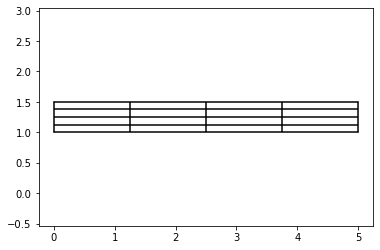

In [3]:
# define geometry map
# undeformed stick
geo = geometry.tensor_product(geometry.line_segment(1,1.5), geometry.line_segment(0,5, intervals=3))
vis.plot_geo(geo, grid=5)
axis('equal');

In [4]:
# rubber, Lamé-coeff.
Mu = 0.003 # [GPa]
Lam = 0.00028416 #  [GPa] (under ass. ny=0.48, almost incompressible)

In [5]:
A_div_1 =  assemble.assemble('Dx(u,0) * p * dx', (kvs_u, kvs_p), bfuns=[('u',1,0), ('p',1,1)], geo=geo)
A_div_2 =  assemble.assemble('Dx(u,1) * p * dx', (kvs_u, kvs_p), bfuns=[('u',1,0), ('p',1,1)], geo=geo)
A_div= bmat([[A_div_1, A_div_2 ]])
#print(shape(A_div))

A_c  = assemble.assemble('p * q * dx', kvs_p, bfuns=[('p',1,0), ('q',1,0)], geo=geo)/Lam
#print(shape(A_c))

In [6]:
# e(u):grad(v)
#grad(u):grad(v)
A_grad_uv = assemble.assemble('inner(grad(u), grad(v))* dx', kvs_u, geo=geo)
#print(A_grad_uv)

AA_grad_uv= block_diag((A_grad_uv,A_grad_uv))

A_div_11 = assemble.assemble('Dx(u,0) * Dx(v,0) * dx', kvs_u, geo=geo)
A_div_21 = assemble.assemble('Dx(u,0) * Dx(v,1) * dx', kvs_u, geo=geo)
A_div_12 = assemble.assemble('Dx(u,1) * Dx(v,0) * dx', kvs_u, geo=geo)
A_div_22 = assemble.assemble('Dx(u,1) * Dx(v,1) * dx', kvs_u, geo=geo)
A_t = bmat([[A_div_11, A_div_21], [A_div_12, A_div_22]])

A_grad = Mu * (AA_grad_uv + A_t)
#print(shape(A_grad))

In [7]:
# assemble the System matrix
A = scipy.sparse.bmat(
    [[A_grad, A_div.T],
     [A_div,  -A_c]], format='csr')

#print(shape(A))

In [8]:
g_zero = lambda x,y: (0.0) #np.exp(-(x-.8)**2 - (y-.8)**2)  # Dirichlet BC function
f = lambda x,y: (0.0) #(-0.5) #3 * np.sin(10*x) * np.cos(10*y) # source term

def g_zero(x, y): return (0.0, 0.0) # vector
# set Dirichlet boundary conditions (vector valued)
bcs = assemble.compute_dirichlet_bcs(kvs_u, geo, [('left', g_zero)])

# compute right-hand side from function f, (F,G=0)
rhs = assemble.inner_products(kvs_u, f, f_physical=True, geo=geo).ravel()
rhs= np.hstack((rhs,rhs)) # F= (f,f) 
rhs = np.pad(rhs, (0,shape(A_c)[0])) # (F,G)

#def g(x,y): return (-3e-7) # Neumann BC function

def g0(x,y):
    if (x>4).all():
        return -3e-7 # set force at distal end only
    else:
        return 0
    
def g(x,y):
    #print(x)
    if isinstance(x,numpy.float64):
        #print( (g0(x,y)) )
        return (g0(x,y))
    #print (([g0(xi,0) for xi in np.nditer(x)]))
    return ([g0(xi,0) for xi in np.nditer(x)])


gn= assemble.assemble('g*v *ds', kvs_u, geo=geo, g=g, boundary='top').ravel()
# print(gn)
g0 = np.zeros(shape(gn)[0])

idx_g= assemble.boundary_dofs(kvs_u,'top',ravel=True) # gives us all boundary dofs

# incorporate neumnann boundary condition

shape_a= shape(A_grad)[0]
nbc= np.zeros(shape(A)[0])
for i in range(len(idx_g)):
    nbc[idx_g[i]]= g0[i] # x-coord
    nbc[idx_g[i]+shape_a//2]= gn[i] # y-coord

#print(shape(rhs))
#print(shape(nbc))
#print(nbc)

In [9]:
#LS = assemble.RestrictedLinearSystem(A, rhs, bcs)
LS = assemble.RestrictedLinearSystem(A, nbc+rhs, bcs)

u = scipy.sparse.linalg.spsolve(LS.A, LS.b)
u =  LS.complete(u)
#print(A)
print(u)
#print(nbc+rhs)
#print(bcs)

[ 0.00000000e+00 -8.77259808e-04 -2.49344463e-03 ...  6.21777843e-08
 -1.87861425e-08 -9.98758922e-09]


In [10]:
#split the solution into its components (velocity and pressure)
N = np.prod(tuple(kv.numdofs for kv in kvs_u))
u1 = u[:N].reshape(m_u)
u2 = u[N:2*N].reshape(m_u)
U = np.stack((u1,u2), axis=-1)

displ = geometry.BSplineFunc(kvs_u, U) 

In [11]:
# evaluate displacement over a grid in the parameter domain
xgrid = linspace(0, 1, 20)
#ygrid = linspace(0, 1, 5)
xygrid = (xgrid, xgrid)

G = geo.grid_eval(xygrid)
dis = displ.grid_eval(xygrid)


In [12]:
def plot_grid(x,y, ax=None, **kwargs):
    ax = ax or plt.gca()
    segs1 = np.stack((x,y), axis=2)
    segs2 = segs1.transpose(1,0,2)
    ax.add_collection(LineCollection(segs1, **kwargs))
    ax.add_collection(LineCollection(segs2, **kwargs))
    ax.autoscale()

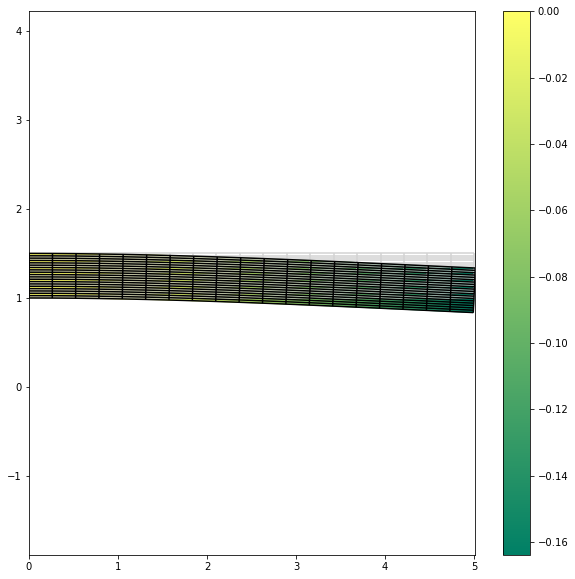

In [13]:
# plot deformation
#plt.subplot(226)
figsize(10,10)
fig, ax = plt.subplots()

plot_grid(G[...,0], G[...,1], ax=ax, color="lightgrey")
plot_grid(G[...,0]+dis[...,0], G[...,1]+dis[...,1], ax=ax, color="black")

# colormesh w.r.t. displacement & deformed quater annulus
pcolormesh(G[...,0]+dis[...,0], G[...,1]+dis[...,1], dis[...,1], cmap='summer', shading='gouraud');
colorbar();

axis('equal');

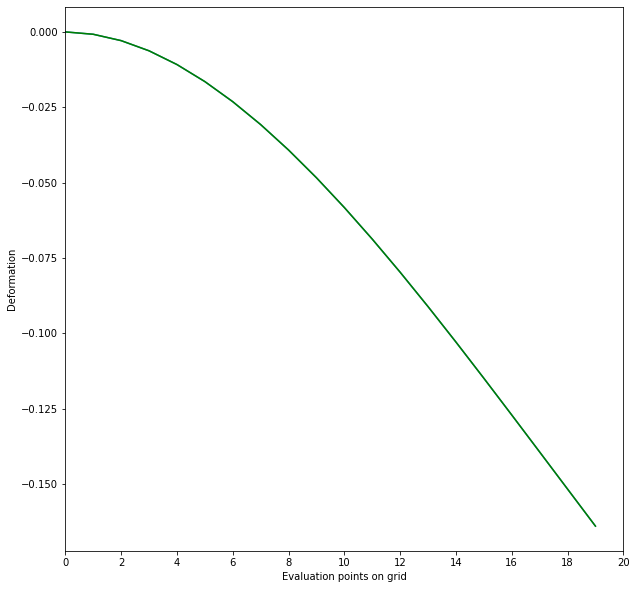

In [14]:
y_val=[]
for i in range(len(dis)):
    y_val = np.append(y_val,dis[0,i,1])

fig, ax = plt.subplots()
ax.set_ylabel('Deformation')
ax.set_xlabel('Evaluation points on grid')
  
ax.set_xlim(0, 20)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.plot(y_val)
ax.plot(y_val, color='g', label='p3')


#print(y_val)
#plt.plot(y_val, color ='tab:blue') 
#plt.xlim([0, 20])
plt.show()

#print(dis[0,...,1])